# etex data

In [1]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # using specific GPU
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.logging.set_verbosity(tf.logging.ERROR)

from compatible.likelihoods import MultiClass, Gaussian
from compatible.kernels import RBF, White
from gpflow.models.svgp import SVGP
from gpflow.training import AdamOptimizer, ScipyOptimizer
from scipy.stats import mode
from scipy.cluster.vq import kmeans2
import gpflow
from gpflow.mean_functions import Identity, Linear
from gpflow.mean_functions import Zero
from gpflow import autoflow, params_as_tensors, ParamList
import pandas as pd
import itertools
pd.options.display.max_rows = 999
import gpflow_monitor

from scipy.cluster.vq import kmeans2
from scipy.stats import norm
from scipy.special import logsumexp
from scipy.io import loadmat
from gpflow_monitor import *
print('tf_ver:', tf.__version__, 'gpflow_ver:', gpflow.__version__)
from tensorflow.python.client import device_lib
print('avail devices:\n'+'\n'.join([x.name for x in device_lib.list_local_devices()]))
from jack_utils.common import time_it
import sys
import gpflow.training.monitor as mon

# our impl
from dgp_graph import *

tf_ver: 1.15.0 gpflow_ver: 1.5.0
avail devices:
/device:CPU:0
/device:XLA_CPU:0
/device:GPU:0
/device:XLA_GPU:0


Using TensorFlow backend.


In [2]:
plt.rcParams['figure.dpi'] = 100
np.random.seed(123456)

# Load data

In [3]:
path = './data'

# Load Adjacency
gmat0 = loadmat(os.path.join(path, 'etex_gmat.mat'))['gmat']
print('raw adj shape:', gmat0.shape)

raw adj shape: (168, 168)


In [4]:
def normalize_data(data, mu, std):
    res = (data-mu) / std
    return res
    #return data

def unnormalize_data(data, mu, std):
    res = data * std + mu
    return res
    #return data

In [5]:
trX0 = loadmat(os.path.join(path, 'etex_trX.mat'))['X_train']
trY0 = loadmat(os.path.join(path, 'etex_trY.mat'))['Y_train']

teX0 = loadmat(os.path.join(path, 'etex_teX.mat'))['X_test']
teY0 = loadmat(os.path.join(path, 'etex_teY.mat'))['Y_test']

In [6]:
ns=0.01
trX0[:,:80] = np.random.rand(*trX0[:,:80].shape)*ns
teX0[:,:80] = np.random.rand(*teX0[:,:80].shape)*ns

In [7]:
trX0.shape

(30, 168)

In [8]:
trY0, teY0 = trY0[:, :, None], teY0[:, :, None]
trX0, teX0 = trX0[:, :, None], teX0[:, :, None]

In [9]:
mu_trX0, std_trX0 = np.mean(trX0, axis=0), np.std(trX0, axis=0)
mu_trY0, std_trY0 = np.mean(trY0, axis=0), np.std(trY0, axis=0)
# mu_teX0, std_teX0 = np.mean(teX0, axis=0), np.std(teX0, axis=0)
# mu_teY0, std_teY0 = np.mean(teY0, axis=0), np.std(teY0, axis=0)

In [10]:
trX = normalize_data(trX0, mu_trX0, std_trX0)
trY = normalize_data(trY0, mu_trY0, std_trY0)
teX = normalize_data(teX0, mu_trX0, std_trX0)
teY = normalize_data(teY0, mu_trY0, std_trY0)

In [11]:
def get_sparsity(adj):
    avg_deg = np.mean([np.count_nonzero(x) for x in adj])
    return 100*(1 - (np.count_nonzero(adj) / (adj.shape[0]**2))), avg_deg

# def thresh(adj0, t=0.1):
#     adj = np.copy(adj0)
#     adj[adj0>t] = 0
#     adj[adj0<=t] = 1
#     return adj

def thresh(adj0, dg=3):
    adj = np.zeros(adj0.shape)
    for i in range(adj.shape[0]):
        adj[i, np.argsort(adj0[i, :])[:dg]] = 1
    return adj

In [12]:
gmat = thresh(gmat0, dg=10)
# gmat = gmat0
get_sparsity(gmat)

(94.04761904761905, 10.0)

gmat = np.eye(gmat.shape[0])

# Data visualization

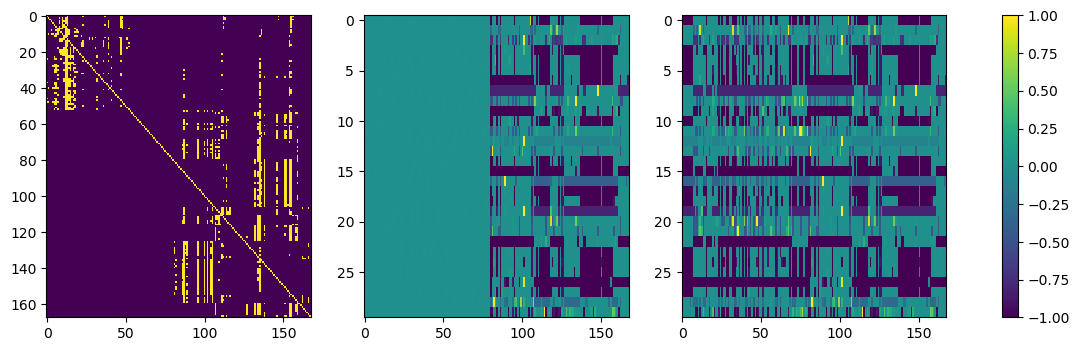

In [13]:
import matplotlib.gridspec as gridspec

fig, axes = plt.subplots(1,3)
# for ax in axes.flat:
axes[0].imshow(gmat, vmin=0, vmax=1, aspect='auto')
axes[1].imshow(trX0.reshape(trX0.shape[0],-1), vmin=-1, vmax=1, aspect='auto')
im = axes[2].imshow(trY0.reshape(trY0.shape[0],-1), vmin=-1, vmax=1, aspect='auto')


plt.subplots_adjust(right=2)
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

In [14]:
def imshow2d(x):
    plt.imshow(x.reshape(x.shape[0], -1))
    plt.colorbar()

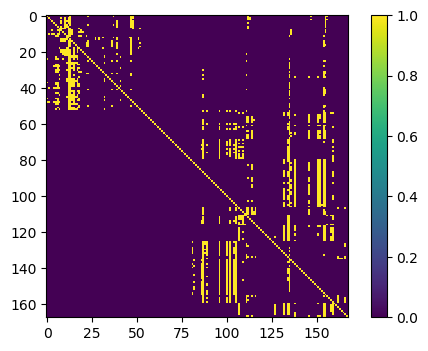

In [15]:
plt.imshow(gmat)
plt.colorbar()

# Training

In [16]:
from sklearn.svm import SVR

svr_pred0 = np.zeros(teY.shape)

for k in range(gmat.shape[1]):
    idx = (gmat[k, :] == 1)
    regx = trX[:, idx, :]
    regx = regx.reshape(regx.shape[0], -1)
    regy = trY[:, k, :].reshape(-1)
    
    svr = SVR(kernel='rbf')
    m = svr.fit(regx, regy)
    
    predx = teX[:, idx, :]
    predx = predx.reshape(predx.shape[0], -1)    
    predy = m.predict(predx)
    
    svr_pred0[:, k, 0] = predy

svr_predY = unnormalize_data(svr_pred0, mu_trY0, std_trY0)

In [17]:
from sklearn import tree

tree_pred0 = np.zeros(teY.shape)

for k in range(gmat.shape[1]):
    idx = (gmat[k, :] == 1)
    regx = trX[:, idx, :]
    regx = regx.reshape(regx.shape[0], -1)
    regy = trY[:, k, :].reshape(-1)
    
    ttree = tree.DecisionTreeRegressor(random_state=0, max_depth=3)
    m = ttree.fit(regx, regy)
    
    predx = teX[:, idx, :]
    predx = predx.reshape(predx.shape[0], -1)    
    predy = m.predict(predx)
    
    tree_pred0[:, k, 0] = predy

tree_predY = unnormalize_data(tree_pred0, mu_trY0, std_trY0)

In [18]:
from sklearn.neural_network import MLPRegressor

mlp_pred0 = np.zeros(teY.shape)

for k in range(gmat.shape[1]):
    idx = (gmat[k, :] == 1)
    regx = trX[:, idx, :]
    regx = regx.reshape(regx.shape[0], -1)
    regy = trY[:, k, :].reshape(-1)
    
    mlp_ = MLPRegressor(hidden_layer_sizes=(100, 100))
    m = mlp_.fit(regx, regy)
    
    predx = teX[:, idx, :]
    predx = predx.reshape(predx.shape[0], -1)    
    predy = m.predict(predx)
    
    mlp_pred0[:, k, 0] = predy

mlp_predY = unnormalize_data(mlp_pred0, mu_trY0, std_trY0)

/home/linaiqi/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/linaiqi/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/linaiqi/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/linaiqi/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conver

In [19]:
from jack_utils.my_metrics import *

In [20]:
# make predictions of our model
sample_X0, sample_Y0 = teX0, teY0.squeeze()
sample_X, sample_Y = teX, teY.squeeze()

In [21]:
mean_base = np.tile(sample_Y0.mean(axis=0).reshape(1,-1), (sample_X0.shape[0], 1))
median_base = np.tile(np.median(sample_Y0, axis=0).reshape(1,-1), (sample_X0.shape[0], 1))


# show rmse of all baselines
metrics = [np_mae, np_rmse, np_mape]
e_ha = [np.round(f(mean_base, sample_Y0.squeeze()), 6) for f in metrics]
e_mid = [np.round(f(median_base, sample_Y0.squeeze()), 6) for f in metrics]
e_svr = [np.round(f(svr_predY.squeeze(), sample_Y0.squeeze()), 5) for f in metrics]
e_tree = [np.round(f(tree_predY.squeeze(), sample_Y0.squeeze()), 5) for f in metrics]
e_mlp = [np.round(f(mlp_predY.squeeze(), sample_Y0.squeeze()), 5) for f in metrics]
print('metrics:\t[mae | rmse | mape]')
print('SVR:\t', e_svr)
print('TREE:\t', e_tree)
print('MLP:\t', e_mlp)
print('day-mean:\t', e_ha)
print('day_median:\t', e_mid)

metrics:	[mae | rmse | mape]
SVR:	 [0.18375, 0.31102, 0.18375]
TREE:	 [0.13753, 0.31004, 0.13753]
MLP:	 [0.16679, 0.31072, 0.1654]
day-mean:	 [0.398054, 0.44586, 0.398054]
day_median:	 [0.351129, 0.495685, 0.351129]
